In [1]:
import os
#os.environ['R_HOME'] = '/home/h/hollenberg/miniconda3/envs/milopy-envv/lib/R' #path to your R installation
#os.environ['R_USER'] = '//home/h/hollenberg/miniconda3/envs/milopy-envv/lib/python3.11/site-packages/rpy2'
#home/h/hollenberg/miniconda3/envs/milopy-envv/bin/python
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
import milopy
import milopy.core as milo
import milopy.plot as milopl
import milopy.utils

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
# path of partly preprocessed HLCA file used in this notebook:
adata_path = "/home/h/hollenberg/MaPra/datasets_seperate/xie.h5ad"

# add annotation when not in adata -> None if annotation already in adata
#add_annotation = "/home/h/hollenberg/MaPra/datasets_seperate/galapagos_radiation_obs_annotation.csv"

sample_identifier = "batch" 
cell_type_identifier = "harmonized_anno" 
covariate_obs = "condition"


In [3]:
adata = sc.read(adata_path)
#if add_annotation is not None:
#    adata.obs = pd.read_csv(add_annotation)

In [4]:
d = 30
k = 50

sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)

In [5]:
milo.make_nhoods(adata, prop=0.1)
adata.obsm["nhoods"]
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
AACCGCGAGCTTTGGT-1_xie,1,2.204111
AAGGTTCGTCGACTAT-1_xie,1,2.651042
AATCGGTAGTACACCT-1_xie,1,2.769273
ACACCCTAGTGGGTTG-1_xie,1,2.211275
ACACCCTTCGTGTAGT-1_xie,1,2.556360
...,...,...
GGGCACTTCGCCTGTT-6_xie,1,1.386831
GTACTTTGTGTTCGAT-6_xie,1,1.490527
GTGGGTCAGCAGCGTA-6_xie,1,2.162918
TACTTACGTTTGACAC-6_xie,1,1.530808


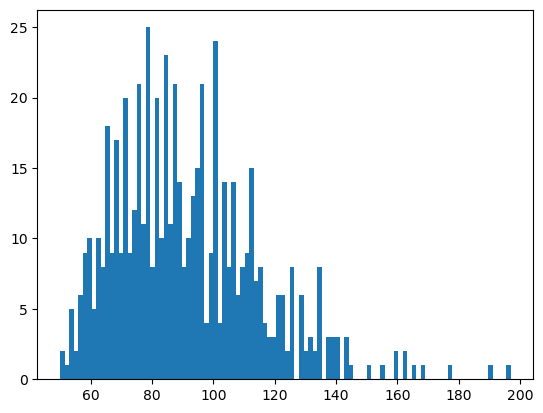

In [6]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [7]:
milo.count_nhoods(adata, sample_col=sample_identifier)
adata.uns["nhood_adata"]

AnnData object with n_obs × n_vars = 590 × 6
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

In [8]:
adata.obs["condition_continuous"] = adata.obs[covariate_obs].astype('category').cat.codes
milo.DA_nhoods(adata, design="~condition_continuous")

In [9]:
adata.uns["nhood_adata"].obs

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,AACCGCGAGCTTTGGT-1_xie,2.204111,-1.856249,10.951047,0.711145,0.412092,0.720516,0.721408
1,AAGGTTCGTCGACTAT-1_xie,2.651042,-1.413255,11.215397,0.431381,0.521098,0.788328,0.788395
2,AATCGGTAGTACACCT-1_xie,2.769273,-0.947303,11.053758,0.241043,0.630442,0.842002,0.843716
3,ACACCCTAGTGGGTTG-1_xie,2.211275,-1.411077,11.452128,0.271445,0.609844,0.832889,0.831460
4,ACACCCTTCGTGTAGT-1_xie,2.556360,1.647839,11.212514,0.708578,0.412766,0.720516,0.721408
...,...,...,...,...,...,...,...,...
585,GGGCACTTCGCCTGTT-6_xie,1.386831,-0.587669,11.547667,0.056755,0.814870,0.913814,0.913325
586,GTACTTTGTGTTCGAT-6_xie,1.490527,-0.874891,10.835194,0.181265,0.676234,0.854343,0.852500
587,GTGGGTCAGCAGCGTA-6_xie,2.162918,1.603940,11.240534,0.744263,0.401291,0.720516,0.718689
588,TACTTACGTTTGACAC-6_xie,1.530808,-0.639236,11.268629,0.071012,0.793438,0.913814,0.913325


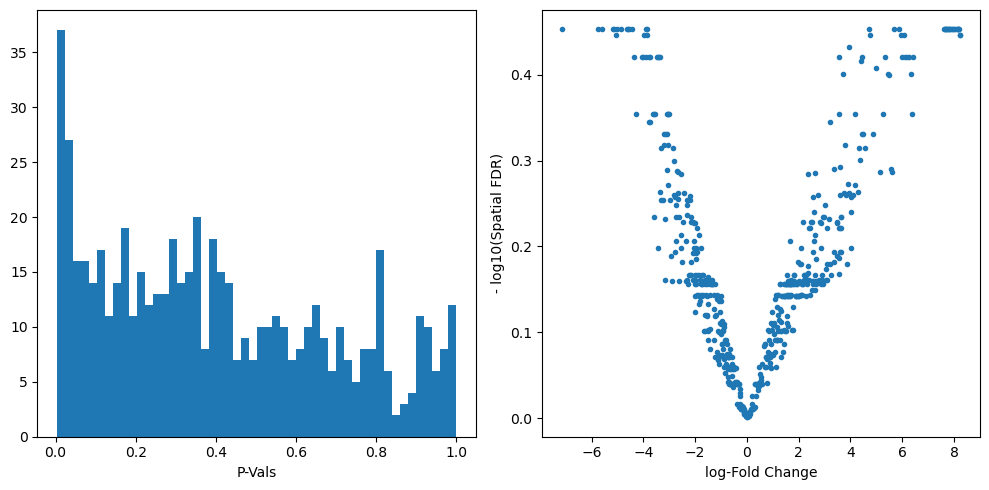

In [10]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [11]:
milopy.utils.build_nhood_graph(adata)

In [12]:
nhood_adata = adata.uns["nhood_adata"].copy()
nhood_adata

AnnData object with n_obs × n_vars = 590 × 6
    obs: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Nhood_size'
    var: 'condition_continuous', 'batch'
    uns: 'sample_col', 'nhood'
    obsm: 'X_milo_graph'
    obsp: 'nhood_connectivities'

In [26]:
#print(nhood_adata.obs)
#print(nhood_adata.var)
#print(nhood_adata.uns)
#print(nhood_adata.obsm)
#print(nhood_adata.obsp)
nhood_adata.X


<590x6 sparse matrix of type '<class 'numpy.float32'>'
	with 2895 stored elements in Compressed Sparse Column format>

In [21]:
adata.uns["nhood_adata"].obs["Nhood_size"]

0       77.0
1       95.0
2       86.0
3      112.0
4       97.0
       ...  
585    114.0
586     64.0
587    106.0
588     89.0
589     84.0
Name: Nhood_size, Length: 590, dtype: float32

StopIteration: 

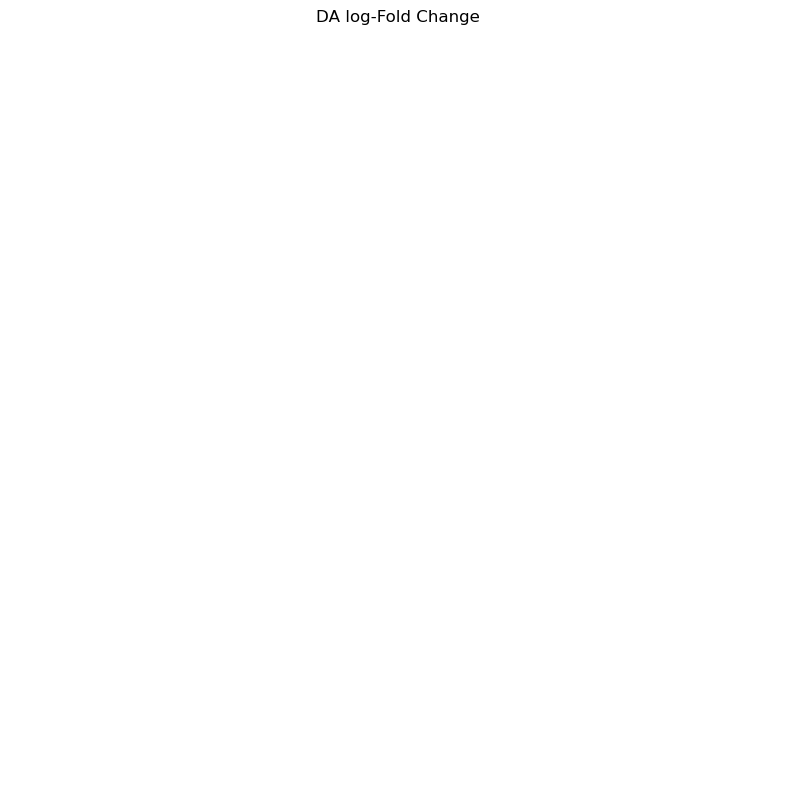

In [24]:
#import milopy.utils 
plt.rcParams["figure.figsize"] = [10,10]
milopl.plot_nhood_graph(adata,
    alpha=0.01, ## SpatialFDR level (1%)
    min_size=2 ## Size of smallest dot 
                       )


## Visualize result by celltype

In [20]:
milopy.utils.annotate_nhoods(adata, anno_col=cell_type_identifier)

ValueError: Must pass 2-d input. shape=()

In [ ]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [ ]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

In [ ]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()